In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import warnings
import copy
import random
from keras import layers, models
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.optimizers import Adam
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
class CNN:
	@staticmethod
	def build(width, height, depth, classes):
		model = models.Sequential()
		inputShape = (height, width, depth)
		model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=inputShape))
		model.add(layers.MaxPooling2D(2,2))
		model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
		model.add(layers.MaxPooling2D(2,2))
		model.add(layers.Flatten())
		model.add(layers.Dense(128, activation = 'relu'))
		model.add(layers.Dense(classes, activation = 'softmax'))
		return model

In [3]:
def train_cnn(train_images, train_labels, val_images = np.array([]),val_labels = np.array([]),epochs = 5):
    model = CNN.build(width=28, height=28, depth=1, classes=10)
    model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy']) #98.97 - adam 99.23 - rmsprop
    if val_images.size!=0 and val_labels.size!=0:
        model.fit(train_images, train_labels, epochs = epochs, batch_size = 60,validation_data=(val_images, val_labels)) 
    else:
        model.fit(train_images, train_labels, epochs = epochs, batch_size = 60) 
    return model

In [4]:
def evalute_cnn(model, test_images, test_labels):
    test_loss, test_acc  = model.evaluate(test_images, test_labels)
    print(f'[INFO] Loss:{test_loss:.4f} Test accuracy: {(test_acc*100):.4f}')

In [5]:
def calculate_f1_score(model, test_images,test_labels):
    test_prob = model.predict(test_images) 
    test_pred = test_prob.argmax(axis=-1)
    f1 = f1_score(test_labels, test_pred, average='weighted')
    print(f'[INFO] F1-Score is:{f1:.4f}')
    return f1

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
train_images , test_images = train_images / 2105.0 , test_images / 255.0
model = train_cnn(train_images,train_labels,test_images,test_labels)
# model = train_cnn(train_images,train_labels)
evalute_cnn(model,test_images,test_labels)
calculate_f1_score(model,test_images,test_labels)




Epoch 1/5


1000/1000 [==============================] - 11s 10ms/step - loss: 0.2481 - accuracy: 0.9247 - val_loss: 0.5125 - val_accuracy: 0.9674
Epoch 2/5
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0654 - accuracy: 0.9801 - val_loss: 0.4795 - val_accuracy: 0.9718
Epoch 3/5
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0451 - accuracy: 0.9861 - val_loss: 0.6232 - val_accuracy: 0.9671
Epoch 4/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.2580 - val_accuracy: 0.9840
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.4533 - accuracy: 0.9779
[INFO] Loss:0.4533 Test accuracy: 97.7900
313/313 [==============================] - 1s 3ms/step
[INFO] F1-Score is:0.9778


0.9778305194706439

In [7]:
def crossover(c1, c2, min_width=1, h_lower_bound=2, h_upper_bound=10):
    height, width, depth = c1.shape
    start_h = np.random.randint(1, height // 2 + 1)
    end_h = np.random.randint(start_h + h_lower_bound, min(start_h + h_upper_bound, height))
    start_w = np.random.randint(0, width - min_width)
    end_w = np.random.randint(start_w + min_width, width)
    c1_sliced = c1.copy()
    c2_sliced = c2.copy()
    c1_sliced[start_h:end_h, start_w:end_w, :] = c2[start_h:end_h, start_w:end_w, :]
    c2_sliced[start_h:end_h, start_w:end_w, :] = c1[start_h:end_h, start_w:end_w, :]
    return c1_sliced, c2_sliced

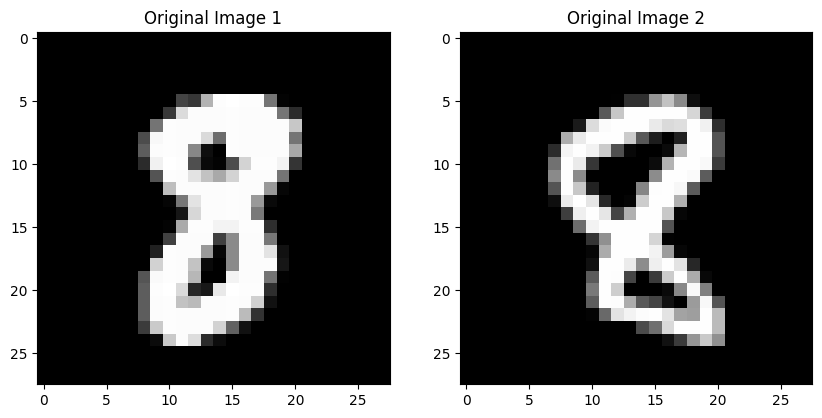

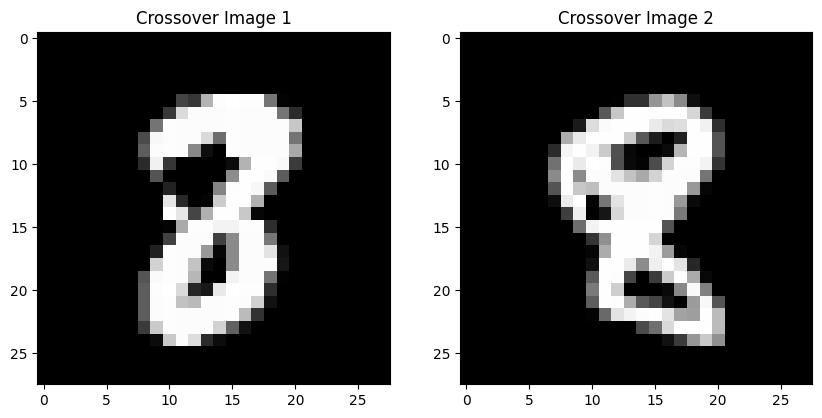

In [8]:
org1 = train_images[np.random.randint(0, len(train_images))]
org2 = train_images[np.random.randint(0, len(train_images))]
c1_crossover, c2_crossover = crossover(org1,org2)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(org1.squeeze(), cmap='gray')
plt.title('Original Image 1')
plt.subplot(1, 2, 2)
plt.imshow(org2.squeeze(), cmap='gray')
plt.title('Original Image 2')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(c1_crossover.squeeze(), cmap='gray')
plt.title('Crossover Image 1')
plt.subplot(1, 2, 2)
plt.imshow(c2_crossover.squeeze(), cmap='gray')
plt.title('Crossover Image 2')
plt.show()

In [9]:
def mutation(m, d=5):
    mutated_image =m.copy()
    step = np.random.randint(-d, d+1)/255.
    mask = np.random.choice([True, False], size=mutated_image.shape)
    mutated_image[mask] += step
    return mutated_image

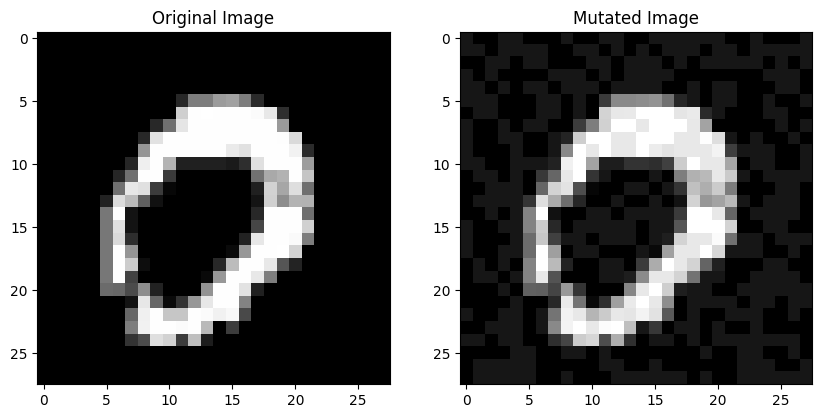

In [10]:
image = train_images[np.random.randint(0, len(train_images))]
mutated_image = mutation(image)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mutated_image.squeeze(), cmap='gray')
plt.title('Mutated Image')
plt.show()

In [11]:
def anneal(alpha, mask_a, d=2, lower_bound=2, upper_bound=10):
    alpha = alpha.copy()
    mask_b = np.random.choice([True, False], size=alpha.shape)
    mask = mask_a ^ mask_b
    step = np.random.randint(-d, d+1, size=alpha.shape)/225.
    start_h = np.random.randint(0, lower_bound)
    end_h = np.random.randint(alpha.shape[0] - upper_bound, alpha.shape[0])
    start_w = np.random.randint(0, lower_bound)
    end_w = np.random.randint(alpha.shape[1] - upper_bound, alpha.shape[1])
    masksliced = np.zeros(alpha.shape, dtype=bool)
    masksliced[start_h:end_h, start_w:end_w] = mask[start_h:end_h, start_w:end_w]
    # print(masksliced.shape)
    # print(alpha.shape)
    alpha[masksliced] += step[masksliced]
    return alpha

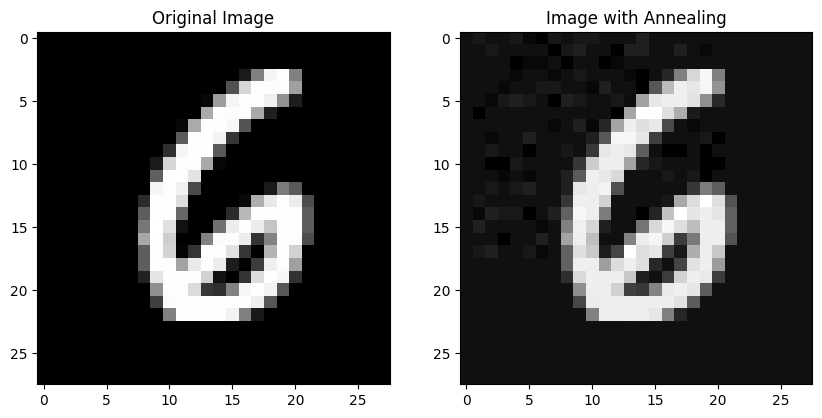

In [12]:
image = train_images[np.random.randint(0, len(train_images))]
mask_a = np.random.choice([True, False], size=image.shape)
anneal_image = anneal(image,mask_a)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(anneal_image.squeeze(), cmap='gray')
plt.title('Image with Annealing')
plt.show()

In [13]:
def calculate_recall(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # print(y_test,y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    # print(recall)
    return recall

In [14]:
def fitness(X, Y, alpha_population, model, lambda_value = 0.1):
    fitness_values = []
    for alpha,alpha_label in alpha_population:
        # print(alpha.shape)
        # print(alpha_label.shape)      
        # X_fitness = np.concatenate([X, alpha], axis=0)
        # Y_fitness = np.concatenate([Y, alpha_label], axis=0)
        # error = lambda_value * calculate_recall(model,X_fitness,Y_fitness)
        error = lambda_value * calculate_recall(model,alpha,alpha_label)
        alpha_fitness = 1 + error - np.linalg.norm(alpha)
        # print(error,np.linalg.norm(alpha),alpha_fitness)
        fitness_values.append(abs(np.max(alpha_fitness)))
    # best_index = np.argmax(fitness_values)
    # print(best_index)
    return fitness_values #if needed put this too alpha_population[best_index]

In [15]:
X_sample = train_images[:4]
y_sample = train_labels[:4]
# print(X_sample.shape)
# print(y_sample.shape)
alpha_population_sample  = [(np.expand_dims(x, axis=0),np.array([y])) for x,y in zip(X_sample, y_sample)]
# alpha_population_sample = [(np.random.rand(1,28, 28, 1), np.random.randint(0, 5, size=(1,))) for _ in range(3)]
# print(alpha_population_sample)
fitness_values = fitness(X_sample, y_sample, alpha_population_sample, model)
print("Fitness values for the sample alpha population:")
print(fitness_values)

1/1 [==============================] - 0s 21ms/step
Fitness values for the sample alpha population:
[0.057820687483609134, 0.13427165605943436, 0.1673901888785786, 0.17421017966771934]


In [16]:
def selection(parents, z=0.5):
    fitness_values = fitness(train_images, train_labels, parents, model)
    num_parents = len(parents)
    num_offspring = int(num_parents * z)
    selected_indices = np.random.choice(num_parents, num_offspring, replace=False, p= fitness_values / np.sum(fitness_values))
    offspring = [parents[i] for i in selected_indices]
    parents_next_gen = [parents[i] for i in range(num_parents) if i not in selected_indices]
    return parents_next_gen, offspring

In [17]:
# X_sample = train_images[:5]
# y_sample = train_labels[:5]
# model = train_cnn(X_sample, y_sample)
# maxpayoff = 0
# exitloop = False
# population = [(np.expand_dims(x, axis=0),np.array([y])) for x,y in zip(X_sample, y_sample)]
# # print(population)
# F_Xtrain = fitness(X_sample, y_sample, population,model)
# print(F_Xtrain)
# gen = 0

# best_index = np.argmax(F_Xtrain)
# print(best_index)
# acurr, currpayoff = population[best_index], F_Xtrain[best_index]  # what is the max show with the fitness example and what is this acurr
# # print(acurr[0],acurr[1])
# print(currpayoff)
# X_sample = np.concatenate([X_sample, acurr[0]], axis=0)
# y_sample = np.concatenate([y_sample, acurr[1]], axis=0)
# model = train_cnn(X_sample, y_sample) 

In [18]:
def twoplayergame_ga(Xtrain, Ytrain, maxiter=100):
    model = train_cnn(Xtrain, Ytrain)
    exitloop = False
    population = [(np.expand_dims(x, axis=0),np.array([y])) for x,y in zip(Xtrain, Ytrain)]
    F_Xtrain = fitness(Xtrain, Ytrain, population, model)
    maxpayoff = np.max(F_Xtrain)
    gen = 0
    while gen < maxiter and not exitloop:
        best_index = np.argmax(F_Xtrain)
        # print(F_Xtrain)
        acurr, currpayoff = population[best_index], F_Xtrain[best_index]
        Xcurr = np.concatenate([Xtrain, acurr[0]], axis=0)
        Ycurr = np.concatenate([Ytrain, acurr[1]], axis=0)
        model = train_cnn(Xcurr, Ycurr, epochs = 1) 
        print("The currpayoff is :", currpayoff)
        if abs(currpayoff - maxpayoff) < 0.1: # the currpayoff issue is coming
            maxpayoff = currpayoff
            parents, offspring = selection(population, 0.5)
            
            new_offspring = []
            for i in range(0,len(offspring)-1,2):
                child1, child2 = crossover(np.squeeze(offspring[i][0], axis=0), np.squeeze(offspring[i+1][0], axis=0))
                new_offspring.append((child1,offspring[i][1]))
                new_offspring.append((child2,offspring[i+1][1]))

            curr_offspring = []
            for mutant,label in new_offspring:
                curr_offspring.append((np.expand_dims(mutation(mutant), axis=0),label))
            
            curr_population = parents + curr_offspring
            population = curr_population.copy()
            F_Xtrain = fitness(Xtrain, Ytrain, population, model)
        else:
            exitloop = True
        
        gen += 1

    final_index = np.argmax(F_Xtrain)
    acurr, maxpayoff = population[final_index], F_Xtrain[final_index]
    return acurr

Epoch 1/5
1/1 [==============================] - 0s 401ms/step - loss: 2.3003 - accuracy: 0.2000
Epoch 2/5
1/1 [==============================] - 0s 7ms/step - loss: 2.2559 - accuracy: 0.4000
Epoch 3/5
1/1 [==============================] - 0s 7ms/step - loss: 2.1912 - accuracy: 0.4000
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 2.0837 - accuracy: 0.2000
Epoch 5/5
1/1 [==============================] - 0s 363ms/step - loss: 2.3008 - accuracy: 0.1667
The currpayoff is : 0.13427165605943436
1/1 [==============================] - 0s 416ms/step - loss: 2.2992 - accuracy: 0.1667
The currpayoff is : 0.07601474465591496
1/1 [==============================] - 0s 483ms/step - loss: 2.3056 - accuracy: 0.0000e+00
The currpayoff is : 0.15855413540174834
1/1 [==============================] - 0s 401ms/step - loss: 2.2999 - accuracy: 0.0000e+00
The currpayoff is : 0.15782068748360922
1/1 [==============================] - 0s 366ms/step - loss: 2.3042 - accuracy: 0.0000e+00
T

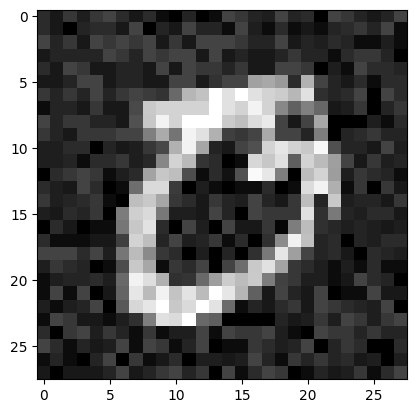

In [19]:
warnings.filterwarnings('ignore')
X_sample = train_images[:5]
y_sample = train_labels[:5]
acurr = twoplayergame_ga(X_sample, y_sample)
print(acurr[1])
plt.imshow(acurr[0].squeeze(), cmap='gray')

In [ ]:
def twoplayergame_sa(Xtrain,Ytrain): 
    model = train_cnn(Xtrain,Ytrain)
    maxpayoff = 0
    exitloop = False
    Tmax = 10
    Tmin = 5
    v = 5 # this should be 50
    p = 0.6
    mask = np.random.choice([True,False], size=Xtrain[0].shape)
    Tcurr = Tmax 
    population = [(np.expand_dims(x, axis=0),np.array([y])) for x,y in zip(Xtrain, Ytrain)]
    random.shuffle(population)
    pop_size = len(population) // 3
    ac = population[:pop_size].copy()
    ag = population[pop_size:2*pop_size].copy()
    an = population[2*pop_size:].copy()  
    evalc = fitness(Xtrain,Ytrain, ac, model)
    maxpayoff = max(fitness(Xtrain,Ytrain, ag, model))
    while not exitloop:
        evalg = fitness(Xtrain,Ytrain, ag,model)
        curr_index = np.argmax(evalg)
        currpayoff = evalg[curr_index]
        print("The current Payoff is:",currpayoff)
        if abs(currpayoff - maxpayoff) < 0.1:
            maxpayoff = currpayoff
            while Tcurr >= Tmin:
                i = 1
                while i <= v:
                    temp = []
                    for ele,label in ac:
                        temp.append((np.expand_dims(anneal(np.squeeze(ele, axis=0),mask),axis = 0),label))
                    an = temp.copy()
                    evaln = fitness(Xtrain,Ytrain, an,model)    
                    print(max(evaln),max(evalc),max(evalg))
                    if max(evaln) > max(evalc):
                        ac = an.copy()
                        evalc = evaln.copy()
                        if max(evalg) < max(evaln):
                            ag = an.copy()
                            evalg = evaln.copy()
                    else:
                        if np.random.random() <= np.exp((max(evaln) - max(evalc)) / Tcurr):
                            ac = an.copy()
                            evalc = evaln.copy()
                    i += 1
                Tcurr *= p
            ag = ac.copy()
        else:
            exitloop = True
    return ag[np.argmax(fitness(Xtrain,Ytrain, ag, model))]
 


In [21]:
X_sample = train_images[:10]
y_sample = train_labels[:10]
ag = twoplayergame_sa(X_sample, y_sample)
# print(ag)
print(ag[1])
plt.imshow(ag[0].squeeze(), cmap='gray')

Epoch 1/5
1/1 [==============================] - 0s 321ms/step - loss: 2.3036 - accuracy: 0.1000
Epoch 2/5
1/1 [==============================] - 0s 4ms/step - loss: 2.2560 - accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 5ms/step - loss: 2.1868 - accuracy: 0.4000
Epoch 4/5
1/1 [==============================] - 0s 8ms/step - loss: 2.0740 - accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 17ms/step
The current Payoff is: 0.23427165605943445
1/1 [==============================] - 0s 21ms/step
0.18440285509150822 0.18999815069107084 0.23427165605943445
1/1 [==============================] - 0s 22ms/step
0.18866502764481274 0.18440285509150822 0.23427165605943445
1/1 [==============================] - 0s 29ms/step
0.19420497466906017 0.18866502764481274 0.23427165605943445
1/1 [==============================] - 0s 25ms/step
0.20069048501977393 0.19420497466906017 0.23427165605943445
1/1 [==============================] - 0s 23ms/step
0.21240235680

In [ ]:
def generate_manipulated_data(images,labels, A_s):
    if len(A_s)==1:
        alphas , alpha_labels = A_s[0][0],A_s[0][1]
    else:
        alphas , alpha_labels =  list(zip(*A_s))
        # print(alphas)
        alphas = np.squeeze(alphas, axis= 1)
        # print(alphas.shape)
        # print(alpha_labels)
        alpha_labels = np.squeeze(alpha_labels)
        # print(alpha_labels.shape)
    X_manipulated = np.concatenate([images, alphas], axis=0)
    Y_manipulated = np.concatenate([labels, alpha_labels], axis=0)
    return X_manipulated, Y_manipulated

In [ ]:
X_sample = train_images[:100]
y_sample = train_labels[:100]
print(X_sample.shape)
print(y_sample.shape)
A_s = [(np.random.rand(1,28, 28, 1), np.random.randint(0, 5, size=(1,))) for _ in range(10)]
# print(alpha_population_sample)
x_check , y_check = generate_manipulated_data(X_sample,y_sample, A_s)
print(x_check.shape)
print(y_check.shape)

(100, 28, 28, 1)
(100,)
(110, 28, 28, 1)
(110,)


In [ ]:
def adversarial_manipulation(X_train,Y_train,X_test,Y_test, M, gametype):
    A_s = [] 
    for i in range(1, M+1):
        if gametype == 'GA':
            a_i = twoplayergame_ga(X_train,Y_train) #remove max_iter
        elif gametype == 'SA':
            a_i = twoplayergame_sa(X_train,Y_train)  
        else:
            raise ValueError("Invalid gametype")
        A_s.append(a_i)

    X_train_manipulated , Y_train_manipulated = generate_manipulated_data(X_train,Y_train, A_s)
    X_test_manipulated , Y_test_manipulated = generate_manipulated_data(X_test,Y_test, A_s)

    cnn_model = train_cnn(X_train,Y_train,X_test,Y_test)
    f1_score_manipulated = calculate_f1_score(cnn_model, X_test_manipulated ,Y_test_manipulated)

    cnn_model_secure= train_cnn(X_train_manipulated, Y_train_manipulated,X_test_manipulated , Y_test_manipulated)
    f1_score_secure = calculate_f1_score(cnn_model_secure, X_test_manipulated,Y_test_manipulated)

    return A_s, f1_score_manipulated, f1_score_secure

In [ ]:
model = train_cnn(train_images[:1000],train_labels[:1000],test_images[:1000],test_labels[:1000])
f1_score_normal = calculate_f1_score(model,test_images,test_labels)

A_s, f1_score_manipulated, f1_score_secure = adversarial_manipulation(train_images[:1000],train_labels[:1000],test_images[:1000],test_labels[:1000], 1, 'SA')
print(f1_score_normal, f1_score_manipulated, f1_score_secure)

Epoch 1/5
17/17 [==============================] - 1s 16ms/step - loss: 2.2376 - accuracy: 0.2740 - val_loss: 1.6840 - val_accuracy: 0.4050
Epoch 2/5
17/17 [==============================] - 0s 9ms/step - loss: 1.5958 - accuracy: 0.5810 - val_loss: 1.7988 - val_accuracy: 0.6520
Epoch 3/5
17/17 [==============================] - 0s 9ms/step - loss: 0.9086 - accuracy: 0.7350 - val_loss: 2.4050 - val_accuracy: 0.7350
Epoch 4/5
17/17 [==============================] - 0s 11ms/step - loss: 0.6443 - accuracy: 0.8190 - val_loss: 5.0394 - val_accuracy: 0.6320
Epoch 5/5
313/313 [==============================] - 1s 2ms/step
[INFO] F1-Score is:0.7328
Epoch 1/5
17/17 [==============================] - 0s 6ms/step - loss: 2.2402 - accuracy: 0.2440
Epoch 2/5
17/17 [==============================] - 0s 6ms/step - loss: 1.5386 - accuracy: 0.5980
Epoch 3/5
17/17 [==============================] - 0s 6ms/step - loss: 0.8474 - accuracy: 0.7530
Epoch 4/5
17/17 [==============================] - 0s 6ms/st

In [ ]:
model = train_cnn(train_images[:1000],train_labels[:1000],test_images[:1000],test_labels[:1000])
f1_score_normal = calculate_f1_score(model,test_images,test_labels)

A_s, f1_score_manipulated, f1_score_secure = adversarial_manipulation(train_images[:1000],train_labels[:1000],test_images[:1000],test_labels[:1000], 1, 'GA')
print(f1_score_normal, f1_score_manipulated, f1_score_secure)

Epoch 1/5
17/17 [==============================] - 1s 20ms/step - loss: 2.2227 - accuracy: 0.2940 - val_loss: 3.0744 - val_accuracy: 0.3700
Epoch 2/5
17/17 [==============================] - 0s 11ms/step - loss: 1.5052 - accuracy: 0.5910 - val_loss: 4.2475 - val_accuracy: 0.5910
Epoch 3/5
17/17 [==============================] - 0s 12ms/step - loss: 0.8356 - accuracy: 0.7610 - val_loss: 2.4627 - val_accuracy: 0.7330
Epoch 4/5
17/17 [==============================] - 0s 12ms/step - loss: 0.6150 - accuracy: 0.8150 - val_loss: 3.4549 - val_accuracy: 0.7180
Epoch 5/5
313/313 [==============================] - 1s 2ms/step
[INFO] F1-Score is:0.8256
Epoch 1/5
17/17 [==============================] - 0s 7ms/step - loss: 2.2154 - accuracy: 0.3520
Epoch 2/5
17/17 [==============================] - 0s 6ms/step - loss: 1.4858 - accuracy: 0.6330
Epoch 3/5
17/17 [==============================] - 0s 6ms/step - loss: 0.8146 - accuracy: 0.7860
Epoch 4/5
17/17 [==============================] - 0s 7ms/

In [ ]:
# model = train_cnn(train_images ,train_labels ,test_images,test_labels)
# f1_score_normal = calculate_f1_score(model,test_images,test_labels)

# A_s, f1_score_manipulated, f1_score_secure = adversarial_manipulation(train_images,train_labels,test_images,test_labels, 1, 'GA')
# print(f1_score_normal, f1_score_manipulated, f1_score_secure)